# PDSCH end-to-end communication
This notebook shows how an end-to-end communication through a 5G Physical Downlink Shared Channel (PDSCH) can be simulated in **NeoRadium** based on 3GPP NR standard. It demonstrate the following steps:

- Creating LDPC encoder object and using it to perform transport block segmentation, LDPC encoding and rate matching based on 3GPP TS 38.212.
- Creating a ``PDSCH`` object and using it to populate a transmitted resource grid based on the encoded transport blocks. During this process, the PDSCH also adds DMRS reference signals in the resource grid based on 3GPP TS 38.211 and TS 38.214.
- Creating a CDL channel model as specified in 3GPP TR 38.901 using the ``CdlChannel`` class. This class and the resource gird created by the ``PDSCH``, are used to calculate a precoding matrix which is then used to precode the resource grid.
- Converting the precoded resource grid to a time-domain (transmitted) waveform through OFDM modulation performed by the ``ofdmModulate`` method of the ``Grid`` class.
- Applying the CDL channel to the transmitted waveform to obtain the received waveform.
- Synchronizing the received waveform by calculating the timing offset using the CDL class object.
- Applying OFDM demodulation to the synchronized received waveform to get a received resource grid.
- Estimating the channel matrix using the DMRS reference signals.
- Equalizing the received resource grid using Minimum mean-squared error (MMSE) equalization to cancel the effect of communication channel.
- Using the ``getLLRsFromGrid`` function of ``PDSCH`` class to extract log-likelihood ratios from the received resource grid.
- Recovering the rate and then LDPC-decoding the transport blocks from the log-likelihood ratios.
- Comparing the received bitstream with the original values used at the beginning of the pipeline.

![PDSCH-Pipeline](PDSCH-Pipeline.png)

Let's get started by importing the **NewRadium** modules used in the notebook.

In [1]:
import numpy as np
import scipy.io
import time

from neoradium import Carrier, PDSCH, CdlChannel, AntennaPanel, LdpcEncoder, Grid, random


### Carrier Configuration
Here using the ``Carrier`` class we define a carrier with 30 KHz subcarrier spacing with 51 resource blocks. The print function prints information about the carrier. Please note that by default a single bandwidth part is defined which covers the whole carrier. Additional bandwidth parts can be added to the carrier if needed.

In [2]:
carrier = Carrier(numRbs=51, spacing=30)  # 51*12*30000 = 18,360,000 for 20 MHz Bandwidth
carrier.print()
bwp = carrier.curBwp                      # The only bandwidth part in the carrier


Carrier Properties:
  Cell Id:               1
  Bandwidth Parts:       1
  Active Bandwidth Part: 0
  Bandwidth Part 0:
    Resource Blocks:    51 RBs starting at 0 (612 subcarriers)
    Subcarrier Spacing: 30 KHz
    CP Type:            normal
    bandwidth:          18.36 MHz
    symbolsPerSlot:     14
    slotsPerSubFrame:   2
    nFFT:               1024
    frameNo:            0
    slotNo:             0



### PDSCH and DMRS Configuration
Now let's use the ``PDSCH`` class to configure the PDSCH communication parameters. Here we choose "Mapping Type A" and "QAM16" modulation (by default). We also set the number of layers to 2 and disable interleaving by setting ``interleavingBundleSize`` to zero.

We then set the DMRS configuration using the ``setDMRD`` method of the ``PDSCH`` class. Here we use DMRS ``configType`` set to 2 with 2 additional symbol time allocations (``additionalPos=2``). Although **NeoRadium** supports both wide band and narrow band precoding, we set the "Precoding RB Group (PRG)" size to 0 which means the same precoding is used for all subcarriers (Wideband Precoding).

In [3]:
pdsch = PDSCH(bwp, interleavingBundleSize=0, numLayers=2, nID=carrier.cellId)
pdsch.setDMRS(prgSize=0, configType=2, additionalPos=2)
pdsch.print()


PDSCH Properties:
  mappingType: A
  nID: 1
  rnti: 1
  numLayers: 2
  numCodewords: 1
  modulation: 16QAM
  portSet: [0, 1]
  symSet:   0   1   2   3   4   5   6   7   8   9  10  11  12  13
  prbSet:   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
           20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39
           40  41  42  43  44  45  46  47  48  49  50
  interleavingBundleSize: 0
  PRG Size: Wideband
  Bandwidth Part:
    Resource Blocks:    51 RBs starting at 0 (612 subcarriers)
    Subcarrier Spacing: 30 KHz
    CP Type:            normal
    bandwidth:          18.36 MHz
    symbolsPerSlot:     14
    slotsPerSubFrame:   2
    nFFT:               1024
    frameNo:            0
    slotNo:             0
  DMRS:
    configType: 2
    nIDs: []
    scID: 0
    sameSeq: 1
    symbols: Single
    typeA1stPos: 2
    additionalPos: 2
    cdmGroups: [0, 0]
    deltaShifts: [0, 0]
    allCdmGroups: [0]
    symSet: [ 2  7 1

### Channel Coding Configuration
Now it is time to define the parameters of LDPC channel coding. **NeoRadium** provides the ``LdpcEncoder`` and ``LdpcDecoder`` classes. These classes can be used to perform data segmentation/de-segmentation, rate-matching/rate-recovery, and encoding/decoding. Here we first set our desired code rate, then create an ``LdpcEncoder`` object that will be used for LDPC encoding.

In [4]:
codeRate = 490/1024
ldpcEncoder = LdpcEncoder(baseGraphNo=1, modulation=pdsch.modems[0].modulation, 
                          txLayers=pdsch.numLayers, targetRate=codeRate)


### Resource Grid Creation and Mapping
Now that we have created the PDSCH and LDPC encoder objects, we can use them to perform channel coding and resource mapping. In the following cell, we first create a resource grid object using the ``getGrid`` method of the ``PDSCH`` object. This will create a resource grid, creates the DMRS reference signals and puts them in the specified locations in the resource grid.

The method ``getTxBlockSize`` is used to calculate the transport block size(s) based on the resources available in the grid for data transmission at the specified code rate. This function calculates the the transport block size based on 3GPP TS 38.214.

Once we have the transport block size, we create random bits for transmission using the utility function ``makeRandomBits``.

The function ``getBitSizes`` returns total bit capacity of the resource grid for each code word. This is the total number of encoded data bits that can be transmitted using the resource grid. It is used to perform rate-matching by the ``LdpcEncoder`` class.

The function ``getRateMatchedCodeWords`` performs segmentation, rate-matching, and LDPC encoding in a single call. The output contains the encoded bits for each codeword.

Once we have the rated-matched encoded bits, we can map them to the available resources in the resource grid. This is exactly what the ``populateGrid`` method of the ``PDSCH`` class does. This function first converts bits to complex symbols using the QAM modulation and then assigns the symbols to the available resource elements in the resource grid at different time, frequency, and layer locations.

The ``drawMap`` method of the ``Grid`` class is used here to show the allocation of data and DMRS in the resource grid.

TX Block Size: 30216
Number of bits: 63648
Size of the rate-matched coded block: 63648
Grid Allocation Stats:
  GridSize: 17136
  DMRS: 1224
  PDSCH: 15912


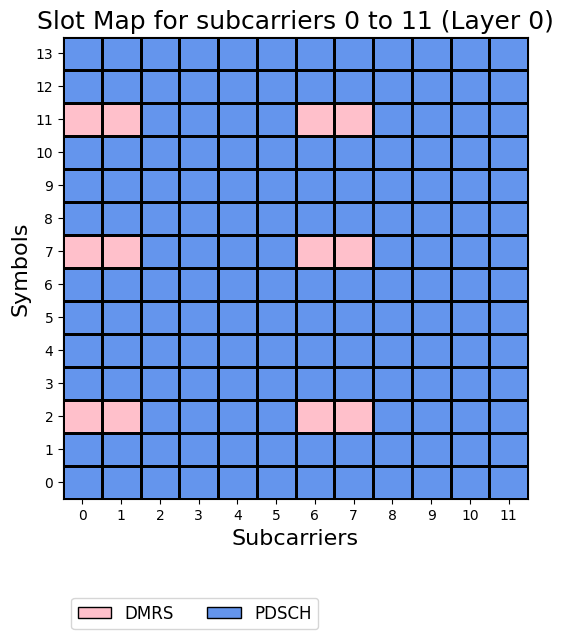

In [5]:
random.setSeed(123)                          # Making the results reproducible.
grid = pdsch.getGrid()                       # Create a resource grid already populated with DMRS 
txBlockSize = pdsch.getTxBlockSize(codeRate) # Calculate the Transport Block Size based on 3GPP TS 38.214 
txBlock = random.bits(txBlockSize[0])        # Create random binary data
        
numBits = pdsch.getBitSizes(grid)            # Actual number of bits available in the resource grid

# Now perform the segmentation, rate-matching, and encoding in one call:
rateMatchedCodeWords = ldpcEncoder.getRateMatchedCodeWords(txBlock, numBits[0])

# Now populate the resource grid with coded data. This includes QAM modulation and resource mapping.
pdsch.populateGrid(grid, rateMatchedCodeWords)

# Store the indexes of the PDSCH data in pdschIndexes to be used later.
pdschIndexes = pdsch.getReIndexes(grid, "PDSCH")   

print("TX Block Size:", txBlockSize[0])
print("Number of bits:", numBits[0])
print("Size of the rate-matched coded block:", rateMatchedCodeWords.shape[0])

# Get statistics about the grid resource allocation
gridStats = grid.getStats()
print("Grid Allocation Stats:")
for key, value in gridStats.items():
    print("  %s: %d"%(key, value))
    
# Draw the map of grid showing the data and DMRS in the first RB of the BWP.
grid.drawMap()

### Channel Simulation and Precoding
The next step in the pipeline is the precoding process. In practice the precoding information is extracted at the UE side (The receiver in this case) from the estimated channel. Since we are demonstrating only a downlink communication here, we assume that the precoding matrix is somehow available. 

To calculate the precoding matrix we first need to define the channel model. Here we use a CDL channel model as specified in 3GPP TR 38.901. The ``CdlChannel`` class is used to create a channel model object. Here we are using a CDL-C model which simulates NLOS communication. We use delay spread of 300 ns and a doppler shift of 5 Hz. We also use a small MIMO configuration with 8 transmitter antenna and 2 receiver antenna. The ``print`` function of the ``CdlChannel`` class can be used to show all properties of the CDL channel model.

To calculate the precoding matrix, we first get the channel matrix from the ``CdlChannel`` object. The channel matrix is a 4-D complex tensor of size ``l``x``k``x ``Nr``x``Nt``. Where ``l``, ``k``, ``Nr``, and ``Nt`` are the number of time symbols (14), the number of subcarriers (51x12=612), the number of receiver antenna (2), and the number of transmitter antenna (8) respectively. 

Once we have the channel matrix, the ``getPrecodingMatrix`` method of the ``PDSCH`` class is called to calculate and return the precoding matrix.

To precode the resource grid, we simply call the ``precode`` method of the ``Grid`` class passing in the precoding matrix.

In [6]:
# Creating a CdlChannel object:
f0 = 4e9  # Carrier Frequency
channel = CdlChannel(bwp, 'C', delaySpread=300, carrierFreq=f0, dopplerShift=5,
                     txAntenna = AntennaPanel([2,4], polarization="|"),  # 8 TX antenna
                     rxAntenna = AntennaPanel([1,2], polarization="|"))  # 2 RX antenna
# channel.print()                                       # Unremark to pring all channel information

# Getting the Precoding Matrix, and precoding the resource grid
channelMatrix = channel.getChannelMatrix()              # Get the channel matrix
precoder = pdsch.getPrecodingMatrix(channelMatrix)      # Get the precoder matrix from the PDSCH object
precodedGrid = grid.precode(precoder)                   # Perform the precoding

print("Shape of Channel Matrix:        ", channelMatrix.shape)
print("Shape of Resource Grid:         ", grid.shape)
print("Shape of Precoded Resource Grid:", precodedGrid.shape)


Shape of Channel Matrix:         (14, 612, 2, 8)
Shape of Resource Grid:          (2, 14, 612)
Shape of Precoded Resource Grid: (8, 14, 612)


### OFDM Modulation
To transmit the precoded resource grid it first needs to be transformed to time-domain. The method ``ofdmModulate`` of the ``Grid`` class converts the precoded grid into a set of time-domain waveforms for each transmit antenna. The output of the OFDM modulation is a ``Waveform`` class that contains the waveforms for each transmit antenna.

In [7]:
txWaveform = precodedGrid.ofdmModulate()
# txWaveform contains the waveforms in time domain for each transmitter antenna
print("Shape of txWaveform:", txWaveform.shape)

Shape of txWaveform: (8, 15360)


### Applying the channel model to the transmitted waveform
Now we need to pass the transmitted waveform through our CDL channel model. Since channel models usually delay the signals, to make sure we get the whole waveform on the output end of the channel, we need to append some zeros to the end of the waveform. The number of these zeros depend on the maximum channel delay that can be obtained using the ``getMaxDelay`` method of the ``CdlChannel`` class. The ``pad`` method of ``Waveform`` class append zeros to the end of waveform.

Now the channel model can be applied to the transmitted waveform to obtain the received waveform. This is exactly what the ``applyToSignal`` method of the ``CdlChannel`` class does. The output is another ``Waveform`` object containing the received waveform for each receiver antenna.

In [8]:
# Need to append zeros to the end of signal based on the maximum channel filter delay
maxDelay = channel.getMaxDelay()
print("Max Channel Delay:  ", maxDelay)
txWaveform = txWaveform.pad(maxDelay)

# Applying channel to the transmitted signal
rxWaveform = channel.applyToSignal(txWaveform)
print("Shape of rxWaveform:", rxWaveform.shape)

Max Channel Delay:   87
Shape of rxWaveform: (2, 15447)


### Adding Noise
We can use the ``addNoise`` method of the ``Waveform`` class to add AWGN to the received signal. Since we are adding the noise in the time-domain, the FFT size is also used in the calculation noise variance. So, we are passing both SNR value and the FFT size to the ``addNoise`` method.

In [9]:
noisyRxWaveform = rxWaveform.addNoise(snrDb=30, nFFT=bwp.nFFT)


### Synchronization and OFDM Demodulation
Because of multiple different path delays involved in the channel model, we need to find the best starting point in the received waveform. This is usually done by finding the position of maximum correlation between the received signal and reference signals. The function ``getTimingOffset`` of the ``CdlChannel`` provides this "timing offset" which is the number of samples we need to skip from the beginning of the received waveform.

After synchronization, the waveform can be used for OFDM demodulation to the received resource grid. The class method ``ofdmDemodulate`` creates a ``Grid`` class instance containing the received resource grid.

In [10]:
# Synchronization: Get the timing offset
offset = channel.getTimingOffset()
syncedWaveform = noisyRxWaveform.sync(offset)
print("Timing Offset:                  ", offset)

# OFDM Demodulation
rxGrid = syncedWaveform.ofdmDemodulate(bwp)
print("Shape of received resource grid:", rxGrid.shape)

Timing Offset:                   13
Shape of received resource grid: (2, 14, 612)


### Applying channel in Frequency Domain
You can also use a shortcut method of applying the channel model to the transmitted grid directly without going to time domain. Although this is not exactly what happens in practice, it is sometimes useful (or convenient) to avid the time domain.

The method ``applyChannel`` of the ``Grid`` class can be used to apply a channel matrix to a resource grid. For example:

```
    # Applying the channel matrix to the precoded grid
    rxGrid = precodedGrid.applyChannel(channelMatrix)
```

### Channel Estimation
The input to the channel estimation process is the received resource grid and the known reference signals (in this case DMRS) and the output is the estimated channel. Note that in this case the estimated channel includes the precoding process. That is because the DMRS reference signals were added to the resource grid **before** precoding.

#### Perfect Channel Estimation
For perfect channel estimation, we need to apply precoding to the channel matrix. This can be done by a simple matrix multiplication as shown in the following cell.

#### Practical Channel Estimation
The method ``estimateChannelLS`` of the ``Grid`` class can be used to estimate the channel matrix. This method performs CDM averaging, Least-Squared channel estimation at pilot locations, and applying interpolation to get the whole channel matrix. 


In [11]:
# Perfect channel estimation (Applying the precoding to the channel matrix)
# estChannelMatrix = channelMatrix @ precoder[None,...]

# Practical channel estimation
estChannelMatrix, _ = rxGrid.estimateChannelLS(pdsch.dmrs)    # Un-remark to use practical channel estimation
print("Shape of estimated channel:", estChannelMatrix.shape)


Shape of estimated channel: (14, 612, 2, 2)


### Equalization
Now that we have an estimation of channel matrix, we can use it for equalization. The method ``equalize`` of the ``Grid`` class uses the Minimum mean-squared error (MMSE) equalization algorithm to cancel the effect of the channel in the received resource grid.

It outputs a ``Grid`` object containing the equalized received resource grid and the LLR scaling values which is used later to scale the log-likelihood ratios from the demodulation process.


In [12]:
eqGrid, llrScales = rxGrid.equalize(estChannelMatrix)
print("Shape of equalized grid:", eqGrid.shape)
print("Shape of LLR Scales:    ", llrScales.shape)

Shape of equalized grid: (2, 14, 612)
Shape of LLR Scales:     (2, 14, 612)


### Demodulation, De-mapping, Descrambling
The method ``getLLRsFromGrid`` of the ``PDSCH`` object performs demodulation, de-mapping, and descrambling of the received grid in one call. The output of this process is a set of log-likelihood ratios (LLRs) for the each received codeword extracted from the received resource grid. Note that in this example there is only one codeword.

In [13]:
llrs = pdsch.getLLRsFromGrid(eqGrid, pdschIndexes, llrScales)
print("Length of LLRs for the first code-word:", llrs[0].shape[0])

Length of LLRs for the first code-word: 63648


### Rate Recovery and LDPC decoding
We are close to the end of pipeline. We just need to decode the LLRs to the actual transport blocks. To do this, we need an LDPC decoder object. The method ``getDecoder`` of the ``LdpcEncoder`` class conveniently creates a  decoder object matching the parameters of the encoder.

The function ``recoverRate`` of the LDPC decoder object can then be used to recover the rate of LDPC codewords based on the transport block size. This is based on the procedure specified in 3GPP TS 38.212.

The rate-recovered coded blocks are then ready to be LDPC-decoded using the ``decode`` method of the ``LdpcDecoder`` class (Each coded block is decoded separately). The output is a set of the decoded blocks.


In [14]:
# Create an LDPC Decoder object using the same parameters used to create the encoder. 
ldpcDecoder = ldpcEncoder.getDecoder()

# Do rate recovery (Note: We have only one codeword in this example)
rxCodedBlocks = ldpcDecoder.recoverRate(llrs[0], txBlockSize[0])
print("Shape of rxCodedBlocks: ", rxCodedBlocks.shape)

# LDPC-Decoding
decodedBlocks = ldpcDecoder.decode(rxCodedBlocks, numIter=20)
print("Shape of Decoded Blocks:", decodedBlocks.shape)



Shape of rxCodedBlocks:  (4, 23232)
Shape of Decoded Blocks: (4, 7744)


### CRC checking and De-segmentation
The CRC of each decoded block must be checked and then the decoded blocks need to be merged (de-segmented) to provide the transport blocks. The method ``checkCrcAndMerge`` of the ``LdpcDecoder`` class does exactly this. The output of this method is a decoded transport block wich also contains a transport block CRC appended at the end.

The ``checkCrc`` method of the ``LdpcDecoder`` class can be used to check the transport block CRC.

In [15]:
decodedTxBlockWithCRC, crcMatch = ldpcDecoder.checkCrcAndMerge(decodedBlocks)
print("Shape of decoded transport block:", decodedTxBlockWithCRC.shape)
print("CRC Match for each decoded block:", crcMatch)

txBlockCrcMatch = ldpcDecoder.checkCrc(decodedTxBlockWithCRC,'24A')
print("Transport block CRC Match:       ", txBlockCrcMatch)


Shape of decoded transport block: (30240,)
CRC Match for each decoded block: [ True  True  True  True]
Transport block CRC Match:        True


### Comparing the decoded transport block with the original
We can get the decoded transport block by removing the 24-bit CRC at the end. Then we can compare the results with the original transport block that was created randomly at the beginning of this pipeline.

In [16]:
decodedTxBlock = decodedTxBlockWithCRC[:-24]  # remove the transport block CRC
print("The number of bit mismatches between the decoded transport block and original:",np.abs(decodedTxBlock-txBlock).sum())


The number of bit mismatches between the decoded transport block and original: 0
